# imports

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import copy
import numpy as np
import os
from display_aux import *
from ships import SHIPS
from df_aux import *
from time_aux import *
from file_aux import *
from plot_aux import *
from parse_aux import *
import sys

In [2]:
ships = SHIPS()


In [3]:
%matplotlib ipympl

In [4]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)


# Run definitions

In [5]:
params = {}
params['input_csv_file_name_full'] = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\Combined\\Spire_AIS_Combined_All_20231101_1106_000000000000.csv'
# params['input_csv_file_name_full'] = 'debug_data_base.csv'

params['columns_list_keep'] = None
params['filter_vessels_df_dic'] = {
        'max_time_diff[mins]':['<=',30]
        }
params['reload_level'] = 1
params['reload_df_filt'] = False
params['reload_vessels'] = True
params['save_folder_base'] = './pkl'

params['export_to_excel'] = False
params['ana_vessel_name'] = 'EYVAN'
# params['df_filter_dic'] = {'position_timestamp':['<=','2023-11-01 02:00:00+0000']}
params['df_filter_dic'] = {}

# Load

In [6]:
save_folder = params['save_folder_base']+'/'+ get_file_base_name(params['input_csv_file_name_full'])
df = ships.load_raw_data(params['input_csv_file_name_full'],reload_level=params['reload_level'],save_folder=save_folder)

# filter_df
df = ships.prepare_df(df,reload_level=params['reload_level'],df_filter_dic=params['df_filter_dic'],save_folder=save_folder,columns_list_keep=params['columns_list_keep'])

# data_dic = ships.create_data_dic(df,reload_level=params['reload_level'],save_folder=save_folder)


load_row_data
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
filter_df
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
save df to ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_filt.pkl


In [7]:
display(df.time.min())
display(df.time.max())

Timestamp('2023-11-01 00:00:00+0000', tz='UTC')

Timestamp('2023-11-01 01:27:53+0000', tz='UTC')

In [9]:
import pandas as pd
import numpy as np

def time_diff_convert(time_diff, units='secs'):
    if units == 'secs':
        return time_diff.dt.total_seconds()
    # Add other unit conversions if needed
    return time_diff

def handle_common_time_rows_in_df(df, time_column='time', ID_columns=[]):

    # handle a none list input 
    if (not isinstance(ID_columns,list)):
        ID_columns = [ID_columns]

    # Check if the specified columns exist in the DataFrame
    missing_columns = [col for col in ID_columns + [time_column] if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {', '.join(missing_columns)}")
    
    # Initialize a counter for the number of common time chunks found
    common_time_chunks_count = 0
    
    # Get the total number of chunks
    total_chunks = df.groupby(ID_columns).ngroups
    
    # Function to handle rows with common time values in chunks defined by ID_columns
    def combine_rows(chunk, chunk_number):
        nonlocal common_time_chunks_count
        
        # Sort the chunk by the time_column
        chunk = chunk.sort_values(by=time_column)
        
        # Calculate the time differences in seconds
        time_diff = chunk[time_column].diff()
        time_diff = time_diff_convert(time_diff, units='secs')
        zero_diff_line_numbers = np.where(time_diff == 0)[0]
        
        # Initialize a list to hold the indices of rows to be dropped
        indices_to_drop = []
        
        # Iterate over the indices with zero time differences and combine rows
        for line_number in zero_diff_line_numbers:
            # Ensure we have at least two rows to combine
            if line_number > 0:
                combined_row = chunk.iloc[line_number].combine_first(chunk.iloc[line_number - 1])
                
                # Place the combined row at the index of the first row in the group
                first_index = chunk.index[line_number - 1]
                df.loc[first_index] = combined_row
                
                # Add the index of the current row to the drop list
                indices_to_drop.append(chunk.index[line_number])
                
                common_time_chunks_count += 1  # Increment the counter
        
        # Drop the rows that have been combined
        if (len(indices_to_drop)!=0):
            df.drop(indices_to_drop, inplace=True)
        
        # Print progress every 1000 chunks
        if chunk_number % 10 == 0:
            print(f"Processed chunk {chunk_number} out of {total_chunks}")

    # Apply the function to each group defined by ID_columns
    for chunk_number, (_, chunk) in enumerate(df.groupby(ID_columns, group_keys=False), start=1):
        combine_rows(chunk, chunk_number)

    print(f"Number of common time chunks found: {common_time_chunks_count}")
    
    return df

# Sample DataFrame for testing
data = {
    'ID': [1, 1, 1, 2, 2],
    'time': ['2023-01-01 12:00', '2023-01-01 12:00', '2023-01-02 13:00', '2023-01-03 14:00', '2023-01-03 14:00'],
    'value': [10, np.nan, 30, 40, np.nan],
    'value2': [np.nan, 20, 30, np.nan, 50]
}
# df = pd.DataFrame(data)
# df['time'] = pd.to_datetime(df['time'])

# Call the function
# df = handle_common_time_rows_in_df(df, time_column='time', ID_columns=['mmsi'])

# info_df['min_time_diff[mins]']==0
# item_df = get_item_df(df,item=412888888)

# item_df = handle_common_time_rows_in_df(item_df,ID_columns=['mmsi'])        
# item_df = handle_common_time_rows_in_df(item_df,ID_columns=['mmsi'])        

# print(df)


# map the mmsi's

In [10]:
def explore_mmsi(df):
    groups = df.groupby('mmsi')
    mmsi_dic = {mmsi:group for mmsi,group in groups}
    item_summary_dic = {}
    item_summary_dic['good_name'] = []
    item_summary_dic['nan_name'] = []
    mmsi_summary_dic['multiple_name'] = []

    for i,mmsi in enumerate(mmsi_dic.keys()):
        name = mmsi_dic[mmsi]['name'].unique()
        if name.shape[0]>1:
            mmsi_summary_dic['multiple_name'].append(mmsi)
        elif pd.isna(name):
            mmsi_summary_dic['nan_name'].append(mmsi)
        else:
            mmsi_summary_dic['good_name'].append(mmsi)    

    return mmsi_summary_dic





In [11]:
def get_item_df(data,item,item_type='mmsi',sort_columns=None):
    if (isinstance(data,dict)):
        df_filt = data[item]
    else:
        df_filt = data.loc[df[item_type]==item]


    # df_filt = handle_common_time_rows_in_df(df_filt,ID_columns=item_type)

    if (sort_columns is not None):
        parse_parameter(sort_columns,df.columns)        

        df_filt = df_filt.sort_values(by=sort_columns)

    return df_filt



def get_item_data_stats(item_data,item_type=None,id_column_check=[]):

    if (not isinstance(id_column_check,list)):
        id_column_check = [id_column_check]

    stats_dic = {
        item_type:item_data[item_type].unique().tolist(),
        'len': [item_data.shape[0]],  # Scalar value wrapped in a list
        'min_time':min(item_data['time']),
        'max_time':max(item_data['time']),
        'total_time':max(item_data['time'])- min(item_data['time']),
        'min_time_diff[mins]': round(np.min(time_diff_convert(item_data['time'].diff()))),
        'max_time_diff[mins]': round(np.max(time_diff_convert(item_data['time'].diff()))),
        'mean_time_diff[mins]': round(np.mean(time_diff_convert(item_data['time'].diff()))),
        'min_longitude':(min(item_data['longitude'])),
        'max_longitude':(max(item_data['longitude'])),
        'min_latitude':(min(item_data['latitude'])),
        'max_latitude':(max(item_data['latitude'])),
    }
    stats_dic['span_longitude']  = stats_dic['max_longitude']-stats_dic['min_longitude']
    stats_dic['span_latitude']  = stats_dic['max_latitude']-stats_dic['min_latitude']

    for column in id_column_check:
        stats_dic[f'num_{column}s'] = item_data[column].unique().shape[0]



    return stats_dic



def create_info_df(df,num_lines = None,item_type='mmsi',id_column_check='name'):

    print ('create item_dic')
    groups = df.groupby(item_type)
    item_dict = {name: group for name, group in groups}

    print('create info_df')

    info_df = pd.DataFrame()
    prob_mmsi = []
    item_list = df[item_type].unique()

    if (num_lines != None):
        item_list = item_list[:num_lines]


    for i, item in enumerate(item_list):
        
        if (i % 1000 == 0):
            print(f'processing {item_type} {i} out of {len(item_list)}')
        item_data = get_item_df(item_dict,item,item_type=item_type)  # Assuming get_item_data is defined elsewhere

        item = item_data[item_type].iloc[0]

        if (item_data.shape[0]==1):
            continue
        
        try:
            ships_df_line = pd.DataFrame(get_item_data_stats(item_data,item_type=item_type,id_column_check=id_column_check),index=[item])
        except Exception as e:
            # Print the exception message
            print(item)
            print(f"An error occurred: {e}")
            # Optionally, you can log the error or perform other actions here
            # Exit the program
            sys.exit(1)


        info_df = pd.concat([info_df, ships_df_line])

    info_df = info_df.sort_values(by='len', ascending=False)

    # info_df = info_df.reset_index(drop=True)
    return info_df






In [12]:
# example
# ship_data = get_item_df(df,2335222)
ship_data = get_item_df(df,'AOS VISION',item_type='name')


info_df = create_info_df(df,num_lines=1000,item_type='name',id_column_check=['mmsi'])
info_df.head()

create item_dic
create info_df
processing name 0 out of 1000


,name,len,min_time,max_time,total_time,min_time_diff[mins],max_time_diff[mins],mean_time_diff[mins],min_longitude,max_longitude,min_latitude,max_latitude,span_longitude,span_latitude,num_mmsis
Nan,Nan,40426,2023-11-01 00:00:00+00:00,2023-11-01 01:27:53+00:00,0 days 01:27:53,0,2,0,12.004450,127.821342,3.248965,41.017500,115.816892,37.768535,4097
@@@@@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@@@@@,1808,2023-11-01 00:00:00+00:00,2023-11-01 01:27:50+00:00,0 days 01:27:50,0,47,3,23.573703,127.269852,25.167772,40.839673,103.696148,15.671902,243
0@@@@@@@@@@@@@@@@@@@,0@@@@@@@@@@@@@@@@@@@,312,2023-11-01 00:00:02+00:00,2023-11-01 01:27:16+00:00,0 days 01:27:14,0,140,17,117.770053,127.285880,25.146972,40.010138,9.515827,14.863167,22
ADA,ADA,287,2023-11-01 00:00:02+00:00,2023-11-01 01:26:45+00:00,0 days 01:26:43,0,252,18,25.876322,28.973568,35.537825,40.783287,3.097247,5.245462,2
ELANDRA SPRUCE,ELANDRA SPRUCE,286,2023-11-01 00:00:00+00:00,2023-11-01 01:27:00+00:00,0 days 01:27:00,0,104,18,54.158482,54.556240,26.364305,26.384470,0.397758,0.020165,1


# handle mutiple names per mmsi

In [13]:
def create_subplot_scheme(axes_size=(5, 2), num_axes=1, max_axes_in_row=4):
    """
    Creates a subplot scheme and returns an array of axes.

    Parameters:
    ----------
    axes_size : tuple
        Size of each individual subplot (width, height).

    num_axes : int
        Total number of subplots to create.

    max_axes_in_row : int, optional
        Maximum number of subplots in a row. Default is 4.

    Returns:
    -------
    fig : matplotlib.figure.Figure
        The created figure.

    axes : array-like of matplotlib.axes.Axes
        Array of created subplot axes.
    """
    # Calculate the number of rows and columns
    num_cols = min(max_axes_in_row, num_axes)
    num_rows = (num_axes + num_cols - 1) // num_cols  # Ceiling division to ensure all axes fit

    # Calculate figure size based on individual axes size
    fig_width = axes_size[0] * num_cols
    fig_height = axes_size[1] * num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), constrained_layout=True)
    
    # Flatten the axes array if there are multiple rows or columns
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Hide any unused subplots
    for i in range(num_axes, len(axes)):
        axes[i].set_visible(False)

    return fig, axes[:num_axes]



In [14]:
def parse_parameter(parameter, allowed_values):
    """
    Example function that only accepts specific values for its parameter.

    Parameters:
    - parameter: str, the input parameter which must be one of the allowed values.
    - allowed_values: list, the set of allowed values for the parameter.

    Raises:
    - ValueError: if the parameter is not in the allowed values.
    """
    
    
    if (isinstance(parameter,list)):
        for value in parameter:
            if value not in allowed_values:
                raise ValueError(f"Invalid value '{value}'. Allowed values are: {allowed_values}")
    else: 
        if parameter not in allowed_values:
            raise ValueError(f"Invalid value '{parameter}'. Allowed values are: {allowed_values}")
    


In [20]:
import matplotlib.pyplot as plt



def plot_df_columns(df, columns=None, axes=None, fig_size=(10, 6), title='Plot',x_data_type='index',time_column = 'time',normalize=False,xlim_val  = None, ylim_val = None):
    """
    Plots specified columns from a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - columns: list of column names to plot. If None, all columns are plotted.
    - axes: matplotlib axes object. If None, a new figure and axes are created.
    - fig_size: tuple, the size of the figure.
    - title: str, the title of the plot.
    
    Returns:
    - axes: matplotlib axes object with the plot.
    """
    if columns is None:
        raise ValueError("columns is empty")
    
    elif not isinstance(columns,list):
        columns = [columns]
    
    parse_parameter(columns,df.columns)
    parse_parameter(x_data_type,['index','time'])

    if axes is None:
        fig, axes = plt.subplots(figsize=fig_size)
        created_fig = True
    else:
        created_fig = False

    if (x_data_type=='index'):
        x_data = range(df.shape[0])

    elif (x_data_type=='time'):
        x_data = df[time_column]
    

    for column in columns:
        if (normalize):
            y_data = (df[column]-df[column].min())/(df[column].max()-df[column].min())
        else:
            y_data = df[column]

        axes.plot(x_data, y_data, label=column)
    
    if (x_data_type=='time'):
        axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        for label in axes.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_fontsize(8)
        


    axes.set_title(title)
    axes.legend()
    # if (xlim_val is not None):
    #     axes.xlim(xlim_val)

    # if (ylim_val is not None):
    #     axes.ylim(ylim_val)

    if created_fig:
        plt.show()
    
    return axes



def plot_item_columns(df,item,item_type='mmsi',columns=['latitude','longitude'], axes_size=(3, 2), separate_y=True,normalize=False,x_data_type='index',sort_columms = None,pre_process=None,xlim_val =None,ylim_val = None):
    if not isinstance(item, list):
        item = [item]

    if columns is None:
        raise ValueError("columns is empty")
    
    elif not isinstance(columns,list):
        columns = [columns]

    fig, axes = create_subplot_scheme(axes_size=axes_size, num_axes=len(item))

    # Plotting on the created subplots
    for i, ax in enumerate(axes):
        if i > len(item):
            break

        # Assuming 'ships.get_item_df' is a function to filter the DataFrame by item
        df_filt = get_item_df(df, item[i],item_type=item_type,sort_columns=sort_columms)

        if (pre_process=='remove_bias'):
            for column in columns:
                df_filt.loc[:, column] = df_filt[column] - df_filt[column].mean()


        plot_df_columns(df_filt,columns=columns,axes=ax,x_data_type=x_data_type,title=f'{item_type}={item[i]}',xlim_val=xlim_val,ylim_val=ylim_val)
        
        # # Plotting the specified columns
        # for column in columns:
        #     ax.plot(df_filt[column], label=column)
        # ax.set_title(f'MMSI: {mmsi[i]}')
        # ax.legend()

    plt.show()




# plot_item_columns(df,item[1:3],item_type=item_type,x_data_type='index',columns=['longitude'],sort_columms=['time_seconds'],pre_process='remove_bias',ylim_val=ylim_val)




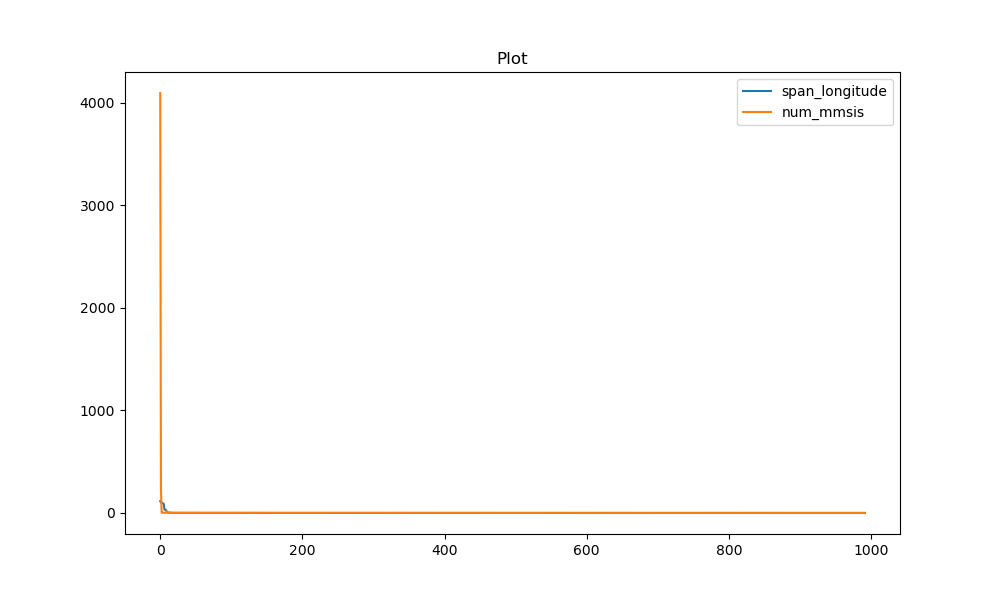

In [17]:
info_df = info_df.sort_values(by='span_longitude',ascending=False)
info_df1 = info_df.reset_index(drop=True)
plot_df_columns(info_df1,columns=['span_longitude','num_mmsis'])
pd.set_option('display.max_rows', 30)


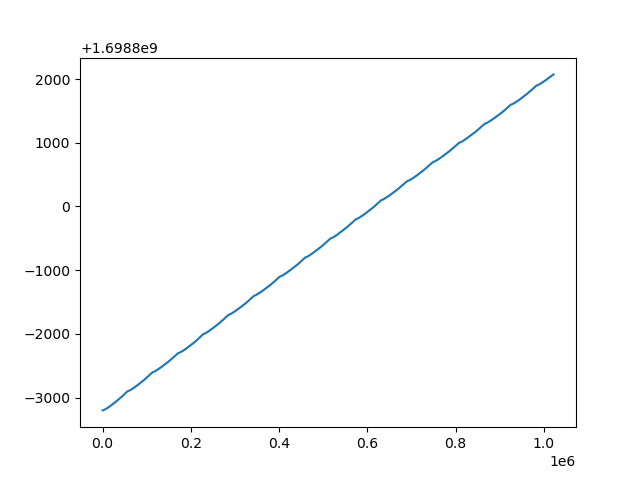

In [18]:
item_df = get_item_df(df,info_df.index[17],item_type='mmsi',sort_columns='time')
diff_data = df['time_seconds']
plt.figure()
plt.plot(diff_data)


# look at good ones

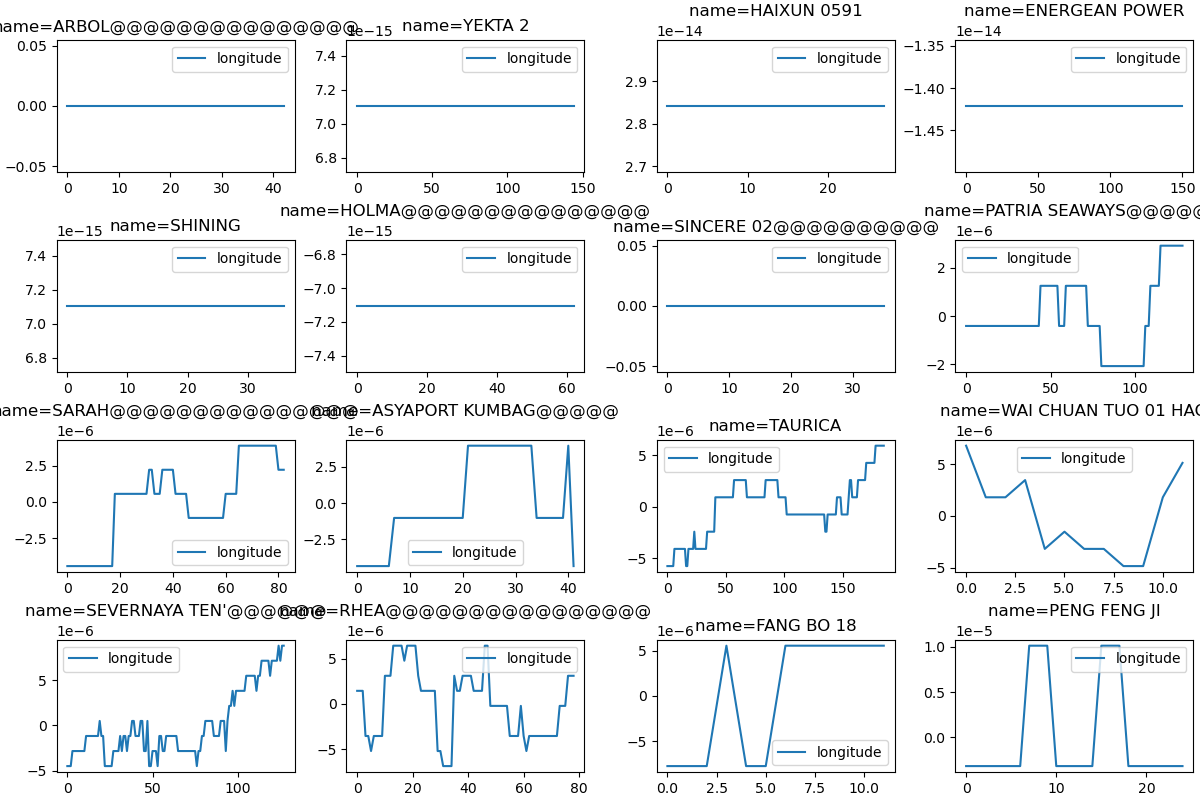

In [21]:
item_type = 'name'
control_item_type = 'mmsi'
info_df = info_df.sort_values('span_longitude')

info_df_filter = {'len': ['>',10],
                    f'num_{control_item_type}s':['==',1]}

info_df_filt = filter_df(info_df,info_df_filter)

item = info_df_filt.index[range(16)].tolist()
ylim_val = [-info_df_filt['span_longitude'].max(),info_df_filt['span_longitude'].max()]
plot_item_columns(df,item[1:2],item_type=item_type,x_data_type='index',columns=['longitude'],sort_columms=['time_seconds'],pre_process='remove_bias',ylim_val=ylim_val)


In [ ]:
info_df_filt['span_longitude'].max()

2.858105000000023

In [ ]:
import pandas as pd

def normalize_columns(df, columns, method='min-max', add_norm_columns=True):
    """
    Normalize specified columns in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns to be normalized.
    columns (list or str): A list of column names or a single column name to normalize.
    method (str): The normalization method to use ('min-max' or 'z-score').
    add_norm_columns (bool): If True, adds normalized columns with suffix '_norm'. If False, replaces the original columns.

    Returns:
    pd.DataFrame: The DataFrame with normalized columns.
    """
    # Ensure columns is a list
    if isinstance(columns, str):
        columns = [columns]
    
    df_normalized = df.copy()
    
    for column in columns:
        if method == 'min-max':
            norm_col = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        elif method == 'z-score':
            norm_col = (df[column] - df[column].mean()) / df[column].std()
        else:
            raise ValueError("Method must be 'min-max' or 'z-score'")
        
        if add_norm_columns:
            df_normalized[column + '_norm'] = norm_col
        else:
            df_normalized[column] = norm_col
    
    return df_normalized

# # Sample DataFrame
# data = {
#     'value1': [10, 20, 30, 40, 50],
#     'value2': [5, 15, 25, 35, 45],
#     'value3': [2, 4, 6, 8, 10]
# }
# df = pd.DataFrame(data)

# # Normalize specified columns and add normalized columns
# columns_to_normalize = ['value1', 'value2']
# method = 'min-max'



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot(x, 
         marker_points=None, 
         marker_points_style = 'o',
         marker_style=None, 
         line_style='-', 
         x_label='Index', 
         y_label='Value', 
         xlim=None, 
         ylim=None, 
         title='', 
         legend=True, 
         figsize=None, 
         color='blue',
         ax=None):
    """
    Plot the values of a NumPy array and optionally highlight marker_points.

    Parameters:
    x (np.ndarray): The NumPy array to plot.
    marker_points (np.ndarray, optional): Indices of the marker_points to highlight. Default is None.
    marker (str, optional): Marker style for the marker_points. Default is 'o'.
    line_style (str, optional): Line style for the plot. Default is '-'.
    x_label (str, optional): Label for the x-axis. Default is 'Index'.
    y_label (str, optional): Label for the y-axis. Default is 'Value'.
    xlim (tuple, optional): Limits for the x-axis in the form (xmin, xmax). Default is None.
    ylim (tuple, optional): Limits for the y-axis in the form (ymin, ymax). Default is None.
    title (str, optional): Title of the plot. Default is 'Plot of NumPy Array'.
    legend (bool, optional): Whether to show a legend. Default is True.
    figsize (tuple, optional): Size of the figure in the form (width, height). Default is None.
    ax (matplotlib.axes.Axes, optional): Axes object to plot on. If None, a new figure and axes are created. Default is None.
    """
    # Ensure x is a NumPy array
    x = np.asarray(x)
    
    # Create a figure and axis if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    
    # Plot the values
    ax.plot(x, line_style, label='Data',marker=marker_style,color=color)
    
    # Highlight marker_points if provided
    if marker_points is not None:
        ax.plot(marker_points, x[marker_points], marker_points_style, linestyle='None', label='marker_points')
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
    # Set limits if provided
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # Add a legend if required
    if legend:
        ax.legend()
    
    # Show the plot if a new figure was created
    if ax is None:
        plt.show()


# # Example usage
# x = np.linspace(0, 10, 100)  # Create a NumPy array of 100 points from 0 to 10
# y = np.sin(x)  # Compute the sine of each point

# plot(y)  # Plot the sine wave

    

In [ ]:
from scipy.signal import find_peaks

ship_df = get_item_df(df,item[0],item_type='name',sort_columns='time')
ship_df = normalize_columns(ship_df,columns=['latitude'],method='min-max')

x = np.array(ship_df['latitude_norm'])[1:]
peak_points = find_peaks(x,distance=3)[0]
plot (x,marker_points=peak_points,line_style='-',marker_style='*',marker_points_style='or')


# Look at bad ones

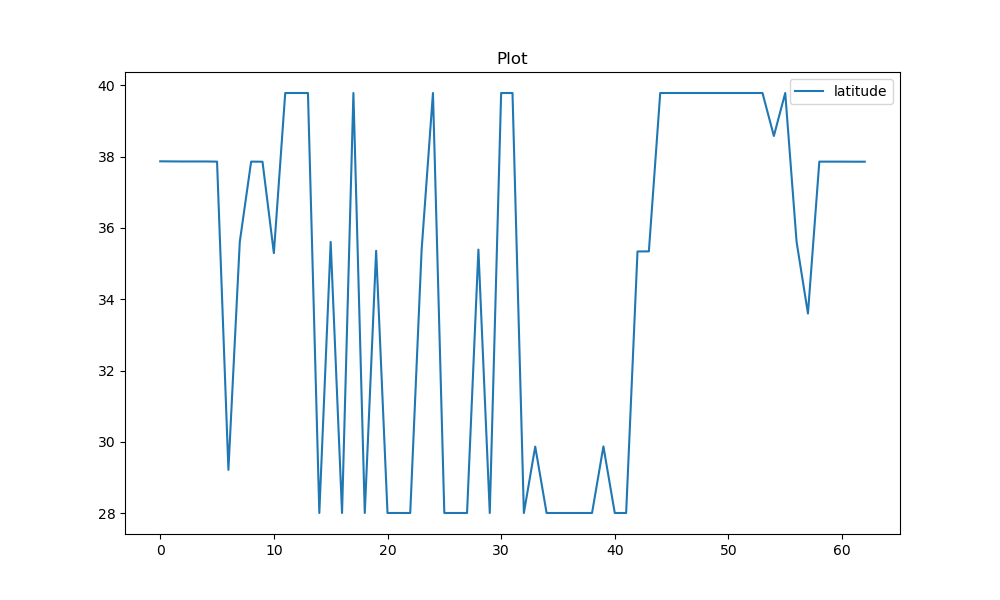

,created_at,time,static_timestamp,mmsi,latitude,longitude,speed,course,heading,imo,name,call_sign,flag,draught,ship_type_code,ship_type,length,width,eta,destination,status,collection_type,time_seconds,org_index
849105,2023-11-01 01:29:34 UTC,2023-11-01 01:13:16+00:00,2023-11-01 01:03:30+00:00,412888888,37.867513,122.224987,3.5,98.7,511.0,NaN,,4231@@@,CN,NaN,30.0,Fishing Vessel,36.0,8.0,NaN,NaN,NaN,dynamic_classB,1.698801e+09,849105
927302,2023-11-01 01:25:16 UTC,2023-11-01 01:20:05+00:00,2023-11-01 01:03:30+00:00,412888888,37.864872,122.232643,3.7,116.0,511.0,NaN,,4231@@@,CN,NaN,30.0,Fishing Vessel,36.0,8.0,NaN,NaN,NaN,dynamic_classB,1.698802e+09,927302
991103,2023-11-01 01:41:51 UTC,2023-11-01 01:25:25+00:00,2023-11-01 01:21:28+00:00,412888888,37.862712,122.238845,3.5,114.1,511.0,NaN,,4231@@@,CN,NaN,30.0,Fishing Vessel,0.0,0.0,NaN,NaN,NaN,dynamic_classB,1.698802e+09,991103
973199,2023-11-01 01:43:06 UTC,2023-11-01 01:23:57+00:00,2023-11-01 01:21:28+00:00,412888888,37.863310,122.237173,3.5,116.2,511.0,NaN,,4231@@@,CN,NaN,30.0,Fishing Vessel,0.0,0.0,NaN,NaN,NaN,dynamic_classB,1.698802e+09,973199
974265,2023-11-01 01:35:56 UTC,2023-11-01 01:24:04+00:00,2023-11-01 01:21:28+00:00,412888888,37.863310,122.237173,3.5,116.2,511.0,NaN,,4231@@@,CN,NaN,30.0,Fishing Vessel,0.0,0.0,NaN,NaN,NaN,dynamic_classB,1.698802e+09,974265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644218,2023-11-01 01:02:28 UTC,2023-11-01 00:55:48+00:00,2023-11-01 00:47:26+00:00,412888888,37.858702,122.219862,4.4,278.3,511.0,NaN,YUGANGDIANQIOO1-76%@,4231@@@,CN,NaN,30.0,Fishing Vessel,0.0,0.0,NaN,NaN,NaN,dynamic_classB,1.698800e+09,644218
640627,2023-11-01 01:12:53 UTC,2023-11-01 00:55:32+00:00,2023-11-01 00:47:26+00:00,412888888,37.858628,122.220617,4.4,278.9,511.0,NaN,YUGANGDIANQIOO1-76%@,4231@@@,CN,NaN,30.0,Fishing Vessel,0.0,0.0,NaN,NaN,NaN,dynamic_classB,1.698800e+09,640627
639226,2023-11-01 00:59:06 UTC,2023-11-01 00:55:26+00:00,2023-11-01 00:47:26+00:00,412888888,37.858628,122.220617,4.4,278.9,511.0,NaN,YUGANGDIANQIOO1-76%@,4231@@@,CN,NaN,30.0,Fishing Vessel,0.0,0.0,NaN,NaN,NaN,dynamic_classB,1.698800e+09,639226
465017,2023-11-01 00:42:07 UTC,2023-11-01 00:40:18+00:00,2023-11-01 00:39:25+00:00,412888888,37.857057,122.243497,4.4,269.2,511.0,NaN,YUGANGDIANQIOO1-76%@,4231@@@,CN,NaN,0.0,Other,0.0,0.0,NaN,NaN,NaN,dynamic_classB,1.698799e+09,465017


In [ ]:

info_df_filter = {'len': ['>',10],
                    'num_names':['>=',2]}

info_df_filt = filter_df(info_df,info_df_filter)
# display(info_df_filt)


bad_mmsi = info_df_filt.index[range(16)].tolist()
# plot_item_columns(df,mmsi,x_data_type='index',columns=['latitude','longitude','time_seconds'],sort_columms='latitued',pre_process='remove_bias')

item_df = get_item_df(df,bad_mmsi[0])
item_df['name'].unique()
item_df = item_df.sort_values(by = 'name')
plot_df_columns(item_df,columns='latitude')
item_df.head(200)